# Assignment 1

* Roll no : 2020102031
* Name : Ruhul Ameen S

## Importing libraries

In [47]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

## Question 1

### 1.2

In [48]:
img = cv2.imread('./calib-object.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

* declaing world points
* and finding corresponding image points using annotating the image

In [49]:
l = 2;

world_points = np.array([
    [0, 0, 0],
    [0, 3*l, 0],
    [0, 6*l, 0],
    [0, 8*l, 0],
    [0,0,3*l],
    [0,3*l,3*l],
    [0,6*l,3*l],
    [0,8*l,3*l],
    [0,0,6*l],
    [0,3*l,6*l],
    [0,6*l,6*l],
    [0,8*l,6*l],
    [3*l,0,0],
    [3*l,3*l,0],
    [3*l,6*l,0],
    [3*l,8*l,0],
    [6*l,0,0],
    [6*l,3*l,0],
    [6*l,6*l,0],
    [6*l,8*l,0],
])

    

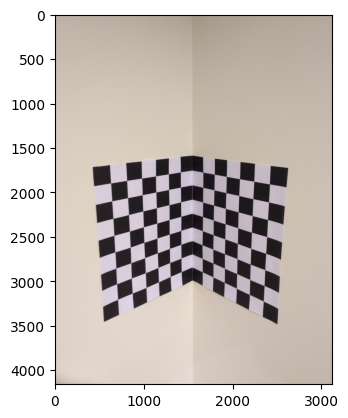

In [50]:
# display the image
plt.imshow(img)
plt.show()

In [51]:
def annotateImage(img_path, annotated_img_path):
    img = cv2.imread(img_path, -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    total_img_points = []

    def highlight_pixel(event, x, y, flags, param):
        if event == cv2.EVENT_FLAG_RBUTTON:
            cv2.circle(img, (x, y), 5, (0, 0, 255), -1)
            cv2.putText(img, "({}, {})".format(x, y), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

            total_img_points.append(np.array([x, y]))
        
    cv2.namedWindow("Image", cv2.WINDOW_NORMAL)
    cv2.setMouseCallback("Image", highlight_pixel)

    while True:
        cv2.imshow("Image", img)
        key = cv2.waitKey(1) & 0xFF

        if key == ord("r"):
            img = cv2.imread(img_path, -1)
            total_img_points = []

        elif key == ord("q"):
            break

    cv2.destroyAllWindows()
    cv2.imwrite(annotated_img_path, img)

    return np.array(total_img_points)

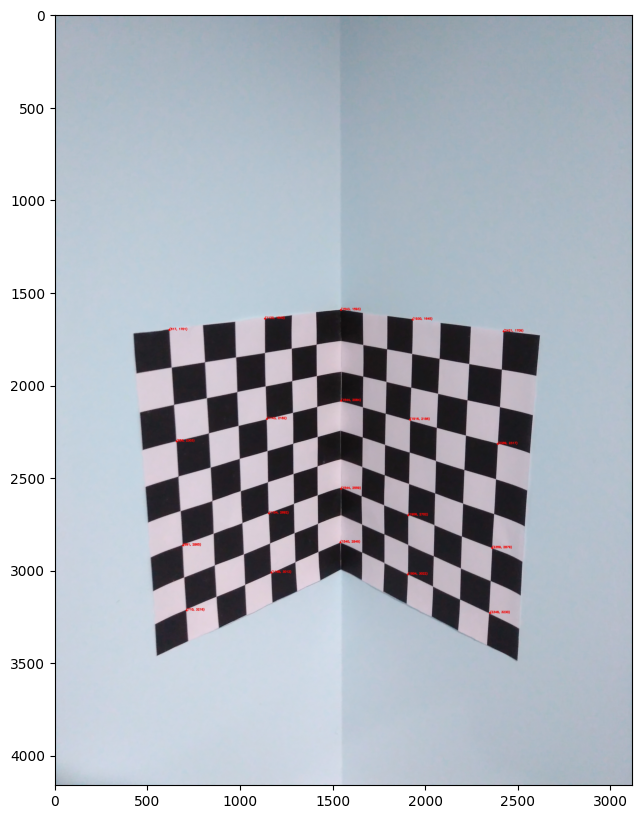

In [52]:
image_points = annotateImage('calib-object.jpg', 'marked_image.jpg')
marked_img = cv2.imread('marked_image.jpg')
marked_img = cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(marked_img)
plt.show()

* estimating projection matrix using the world and image points
* and finding the camera parameters using the projection matrix

In [54]:

def estimateProjectionMatrix(world_points, image_points):
    world_points = np.c_[world_points, np.ones(world_points.shape[0])]
    image_points = np.c_[image_points, np.ones(image_points.shape[0])]
    A = np.zeros((2 * world_points.shape[0], 12))
    for i in range(world_points.shape[0]):
        A[2 * i, :4] = world_points[i]
        A[2 * i, 8:] = -image_points[i, 0] * world_points[i]
        A[2 * i + 1, 4:8] = world_points[i]
        A[2 * i + 1, 8:] = -image_points[i, 1] * world_points[i]

    # solve for the projection matrix
    _, _, V = np.linalg.svd(A)
    P = V[-1].reshape(3, 4)

    return P

In [55]:
def estimateParams(P):
    C = np.array(np.dot(-np.linalg.inv(P[:, :3]), P[:, 3]))

    Q, R = np.linalg.qr(np.linalg.inv(P[:, :3]))
    K = np.linalg.inv(R)
    K /= K[2, 2]
    R =np.transpose(Q)

    return C, K, R

In [56]:
P = estimateProjectionMatrix(world_points, image_points)
C, K, R = estimateParams(P)
# tabulate and print the results
print("Projection Matrix P")
print(tabulate(P, tablefmt='grid'))
print("Calibration Matrix K")
print(tabulate(K, tablefmt='grid'))
print("Rotation Matrix R")
print(tabulate(R, tablefmt='grid'))

Projection Matrix P
+-------------+--------------+--------------+-------------+
| 0.038968    | -0.00365296  | -0.0151771   | -0.693803   |
+-------------+--------------+--------------+-------------+
| 0.00819043  | -0.0419484   |  0.00827353  | -0.71762    |
+-------------+--------------+--------------+-------------+
| 7.17742e-06 | -2.30851e-06 |  7.38079e-06 | -0.00045052 |
+-------------+--------------+--------------+-------------+
Calibration Matrix K
+----------+------------+---------+
| -3650.64 |    9.97634 | 1581.95 |
+----------+------------+---------+
|     0    | 3638.09    | 1946.53 |
+----------+------------+---------+
|     0    |    0       |    1    |
+----------+------------+---------+
Rotation Matrix R
+-----------+-------------+-----------+
| -0.717325 | -0.00264016 |  0.696734 |
+-----------+-------------+-----------+
| -0.150597 | -0.975767   | -0.158745 |
+-----------+-------------+-----------+
|  0.680269 | -0.218798   |  0.699544 |
+-----------+-------------+--

### 1.3

* declaing world points around the wireframe
* finding the corresponding image points using the projection matrix
* overlaying the wireframe on the image

In [57]:
world_points = np.array([
    [7*l, 0, 0],
    [0,0,0],
    [0,0,7*l],
    [0,9*l,7*l],
    [0,9*l,0],
    [7*l,9*l,0],
])

world_points = np.c_[world_points, np.ones(world_points.shape[0])]
print(world_points)

[[14.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0. 14.  1.]
 [ 0. 18. 14.  1.]
 [ 0. 18.  0.  1.]
 [14. 18.  0.  1.]]


In [58]:
image_points = np.array(np.dot(P, world_points.T).T)
image_points = image_points / image_points[:, 2].reshape(-1, 1)
image_points = image_points[:, :2]
image_points = image_points.astype(int)

print(image_points)

[[ 423 1722]
 [1540 1592]
 [2610 1733]
 [2500 3490]
 [1543 2992]
 [ 546 3467]]


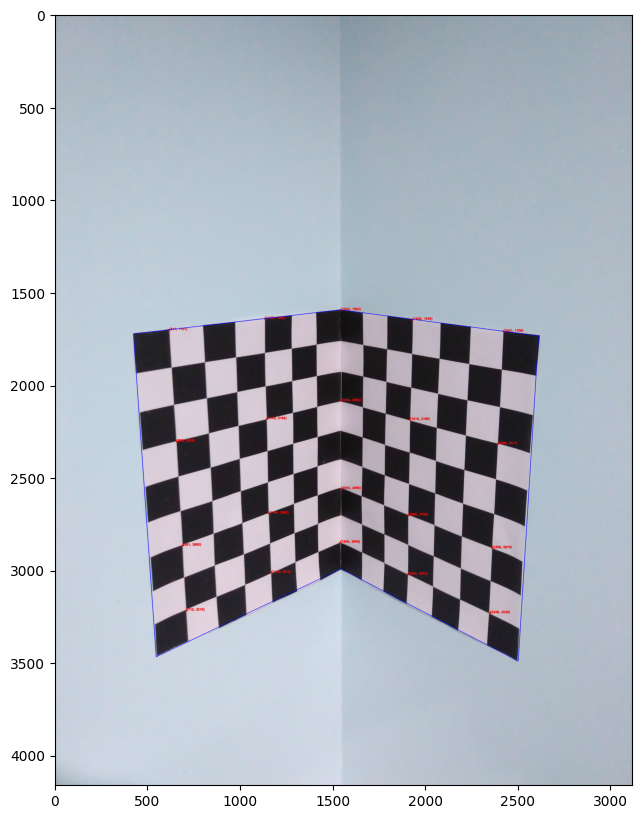

In [59]:
wire_frame =cv2.polylines(marked_img, [image_points], True, (0, 0, 255), 2)
cv2.imwrite('wire_frame.jpg', wire_frame)
plt.figure(figsize=(10, 10))
plt.imshow(wire_frame)
plt.show()

### 1.4

* finding pan, tilt and roll angles using the rotation matrix

In [61]:
def rotation_matrix_to_angles(rotation_matrix):
    r00, r01, r02 = rotation_matrix[0, 0], rotation_matrix[0, 1], rotation_matrix[0, 2]
    r10, r11, r12 = rotation_matrix[1, 0], rotation_matrix[1, 1], rotation_matrix[1, 2]
    r20, r21, r22 = rotation_matrix[2, 0], rotation_matrix[2, 1], rotation_matrix[2, 2]
    alpha = np.arctan2(r21, r22)
    beta = np.arctan2(-r20, np.sqrt(r21**2 + r22**2))
    gamma = np.arctan2(r10, r00)

    return alpha, beta, gamma
alpha, beta, gamma = rotation_matrix_to_angles(R)

print("Pan: {:.2f} degrees".format(np.degrees(alpha)))
print("Tilt: {:.2f} degrees".format(np.degrees(beta)))
print("Roll: {:.2f} degrees".format(np.degrees(gamma)))


Pan: -17.37 degrees
Tilt: -42.86 degrees
Roll: -168.14 degrees


## Question 2

In [137]:
# read the image calib-object.jpg
img2 = cv2.imread('./calib-object.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)


### 2.1

* declaing world points in one plane of the 3d world of chessboard
* finding the corresponding image points using annotating the image
* estimating projection matrix using the world and image points

In [156]:
world_points = np.array([
    [0, 0, 0],
    [0, 3*l, 0],
    [0, 6*l, 0],
    [0, 8*l, 0],
    [3*l,0,0],
    [3*l,3*l,0],
    [3*l,6*l,0],
    [3*l,8*l,0],
    [6*l,0,0],
    [6*l,3*l,0],
    [6*l,6*l,0],
    [6*l,8*l,0],
])
world_points5 = np.array(world_points, dtype=np.float32)
print(world_points5)

[[ 0.  0.  0.]
 [ 0.  6.  0.]
 [ 0. 12.  0.]
 [ 0. 16.  0.]
 [ 6.  0.  0.]
 [ 6.  6.  0.]
 [ 6. 12.  0.]
 [ 6. 16.  0.]
 [12.  0.  0.]
 [12.  6.  0.]
 [12. 12.  0.]
 [12. 16.  0.]]


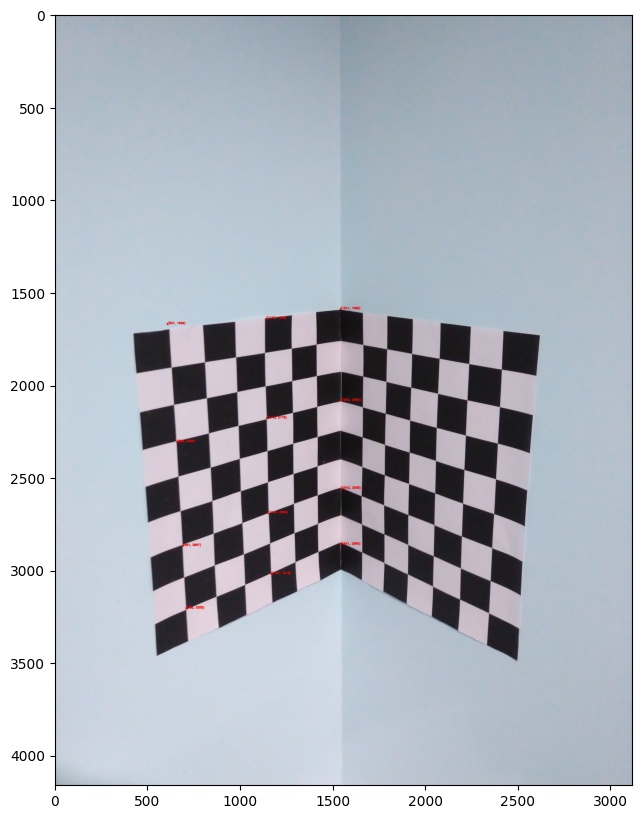

In [158]:
image_points5 = annotateImage('calib-object.jpg', 'marked_image2.jpg')
marked_img2 = cv2.imread('marked_image2.jpg')
marked_img2 = cv2.cvtColor(marked_img2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(marked_img2)
plt.show()

In [159]:
image_points5 = np.array(image_points5, dtype=np.float32)

In [160]:
# calibrate the camera using opencv
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    world_points5.reshape(1,-1,3), 
    image_points5.reshape(1,-1,2), 
    (img2.shape[1], img2.shape[0]),
    None, 
    None
)
print("Camera Matrix K")
print(tabulate(mtx, tablefmt='grid'))
print("Distortion Coefficients")
print(tabulate(dist, tablefmt='grid'))

Camera Matrix K
+--------+---------+---------+
| 2072.8 |    0    | 1312.86 |
+--------+---------+---------+
|    0   | 2495.48 | 1695.26 |
+--------+---------+---------+
|    0   |    0    |    1    |
+--------+---------+---------+
Distortion Coefficients
+----------+----------+------------+-----------+---------+
| 0.921167 | -2.00554 | -0.0732262 | 0.0228093 | 1.77592 |
+----------+----------+------------+-----------+---------+


* declaring the world points in the 3d world of chessboard
* finding the corresponding image points using annotating the image
* estimating projection matrix using the world and image points by keeping the previous camera matrix as the initial guess


In [162]:
world_points6 = np.array([
    [0, 0, 0],
    [0, 3*l, 0],
    [0, 6*l, 0],
    [0, 8*l, 0],
    [0,0,3*l],
    [0,3*l,3*l],
    [0,6*l,3*l],
    [0,8*l,3*l],
    [0,0,6*l],
    [0,3*l,6*l],
    [0,6*l,6*l],
    [0,8*l,6*l],
    [3*l,0,0],
    [3*l,3*l,0],
    [3*l,6*l,0],
    [3*l,8*l,0],
    [6*l,0,0],
    [6*l,3*l,0],
    [6*l,6*l,0],
    [6*l,8*l,0],
])

world_points6 = np.array(world_points6, dtype=np.float32)

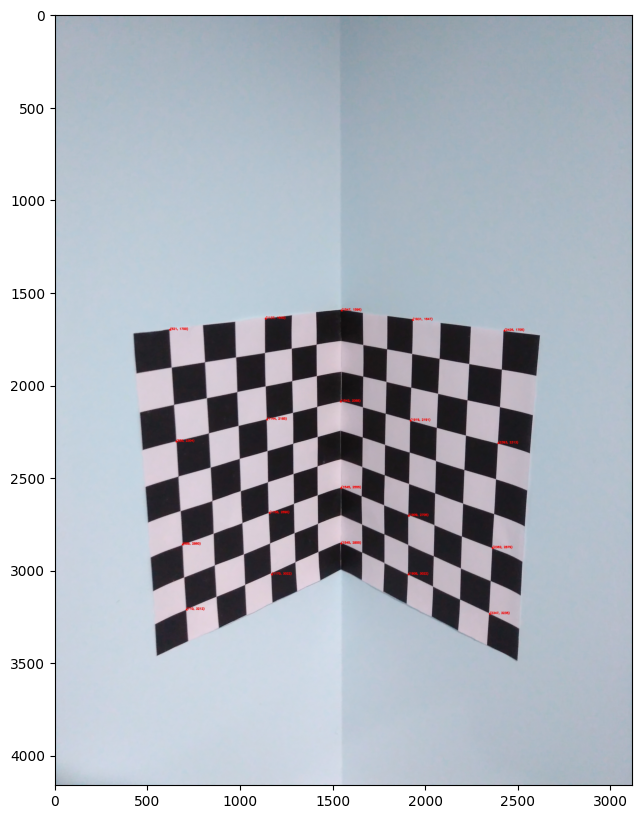

In [163]:
image_points6 = annotateImage('calib-object.jpg', 'marked_image3.jpg')
marked_img3 = cv2.imread('marked_image3.jpg')
marked_img3 = cv2.cvtColor(marked_img3, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(marked_img3)
plt.show()

In [165]:
image_points6 = np.array(image_points6, dtype=np.float32)

In [166]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    world_points6.reshape(1,-1,3), 
    image_points6.reshape(1,-1,2), 
    (img2.shape[1], img2.shape[0]),
    mtx, 
    None,
    flags=cv2.CALIB_USE_INTRINSIC_GUESS
)
print("Camera Matrix K")
print(tabulate(mtx, tablefmt='grid'))
print("Distortion Coefficients")
print(tabulate(dist, tablefmt='grid'))

Camera Matrix K
+---------+---------+---------+
| 3657.06 |    0    | 1579.04 |
+---------+---------+---------+
|    0    | 3649.56 | 1903.88 |
+---------+---------+---------+
|    0    |    0    |    1    |
+---------+---------+---------+
Distortion Coefficients
+----------+---------+------------+------------+---------+
| 0.452513 | -3.9883 | -0.0114685 | 0.00317436 | 11.2079 |
+----------+---------+------------+------------+---------+


In [167]:
R, _ = cv2.Rodrigues(rvecs[0])
C = tvecs[0]
P2 = np.dot(mtx, np.c_[R, C])

* declaing world points around the wireframe
* finding the corresponding image points using the projection matrix
* overlaying the wireframe on the image

In [169]:
world_points7 = np.array([
    [7*l, 0, 0],
    [0,0,0],
    [0,0,7*l],
    [0,9*l,7*l],
    [0,9*l,0],
    [7*l,9*l,0],
])

world_points7 = np.c_[world_points7, np.ones(world_points7.shape[0])]

In [170]:
image_points7 = np.array(np.dot(P2, world_points7.T).T)
image_points7 = image_points7 / image_points7[:, 2].reshape(-1, 1)
image_points7 = image_points7[:, :2]
image_points7 = image_points7.astype(int)

print(image_points7)

[[ 440 1726]
 [1543 1598]
 [2596 1734]
 [2493 3485]
 [1545 2991]
 [ 551 3461]]


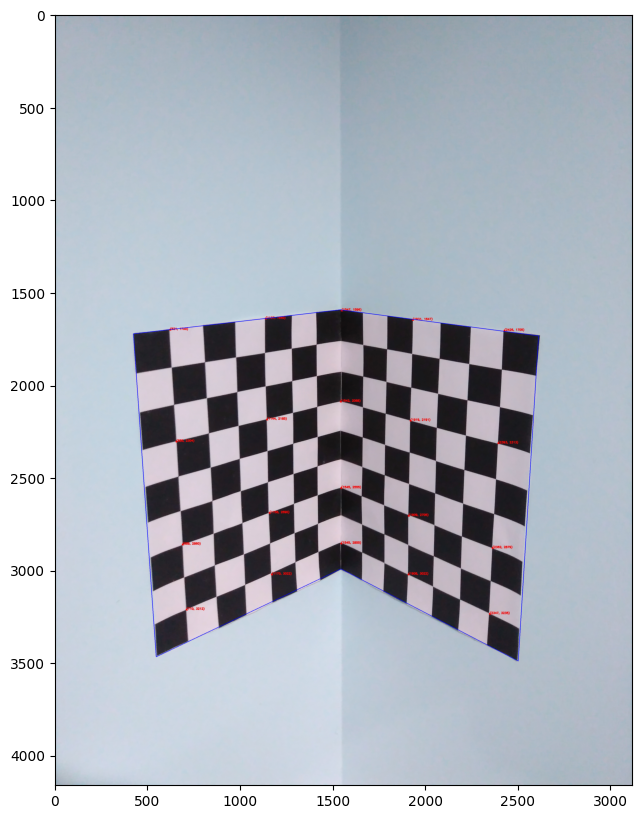

In [172]:
wire_frame3 =cv2.polylines(marked_img3, [image_points], True, (0, 0, 255), 2)
cv2.imwrite('wire_frame3.jpg', wire_frame3)
plt.figure(figsize=(10, 10))
plt.imshow(wire_frame3)
plt.show()

### 2.2

In [65]:
# read the image
img1 = cv2.imread('assign1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)


* declaing world points of the 3d world of chessboard
* finding the corresponding image points using annotating the image
* estimating projection matrix using the world and image points

In [74]:
l1= 2;
world_points1 = [
    [(0, 0, 0)],
    [(0, 2*l1, 0)],
    [(0, 4*l1, 0)],
    [(0, 6*l1, 0)],
    [(2*l1, 0, 0)],
    [(2*l1, 2*l1, 0)],
    [(2*l1, 4*l1, 0)],
    [(2*l1, 6*l1, 0)],
    [(4*l1, 0, 0)],
    [(4*l1, 2*l1, 0)],
    [(4*l1, 4*l1, 0)],
    [(4*l1, 6*l1, 0)],
    [(6*l1, 0, 0)],
    [(6*l1, 2*l1, 0)],
    [(6*l1, 4*l1, 0)],
    [(6*l1, 6*l1, 0)],
]



In [76]:
# make world points as a 3D point vector of vectors.
world_points1 = np.array(world_points1, dtype=np.float32)


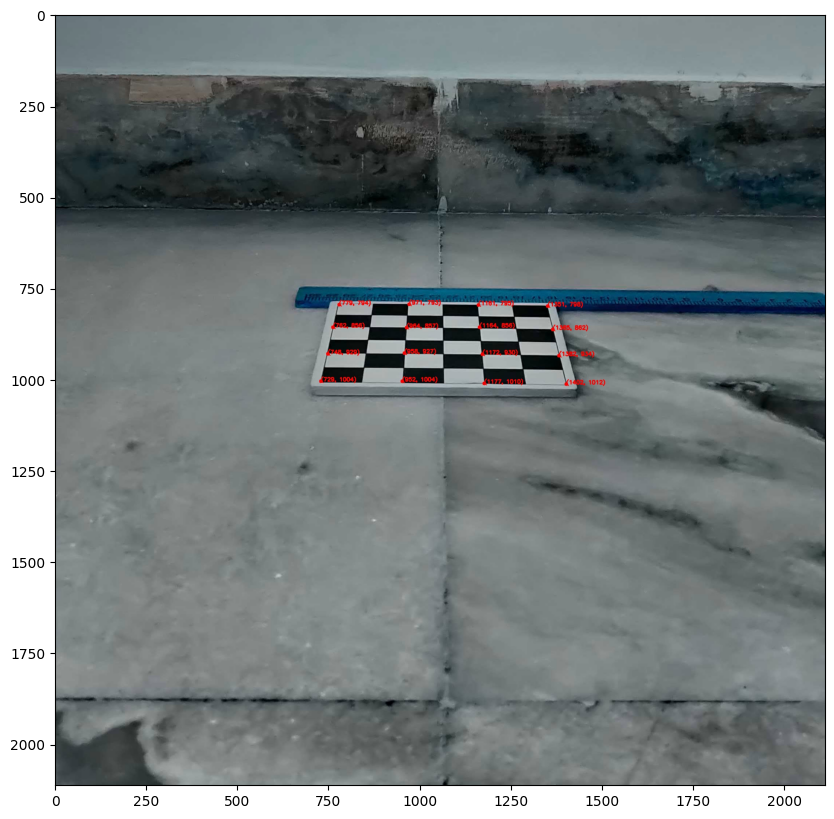

In [105]:
image_points1 = annotateImage('assign1.jpg', 'marked_image1.jpg')
marked_img1 = cv2.imread('marked_image1.jpg')
marked_img1 = cv2.cvtColor(marked_img1, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(marked_img1)
plt.show()

In [106]:
# make image points as a vector of vectors of the 2D image points
image_points1 = np.array(image_points1, dtype=np.float32)

In [107]:
# calibrate the camera using opencv
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([world_points1], [image_points1], img1.shape[1::-1], None, None)
print("Camera Matrix K")
print(tabulate(mtx, tablefmt='grid'))
print("Distortion Coefficients")
print(tabulate(dist, tablefmt='grid'))


Camera Matrix K
+---------+---------+---------+
| 3548.54 |    0    | 1058.46 |
+---------+---------+---------+
|    0    | 2423.51 | 1139.82 |
+---------+---------+---------+
|    0    |    0    |    1    |
+---------+---------+---------+
Distortion Coefficients
+---------+---------+-----------+------------+----------+
| -1.4275 | 45.9262 | 0.0558392 | 0.00695592 | -657.425 |
+---------+---------+-----------+------------+----------+


In [108]:
# get projection matrix
# get R and C
R, _ = cv2.Rodrigues(rvecs[0])
C = tvecs[0]
P1 = np.dot(mtx, np.c_[R, C])


* declaring the world points of the wireframe
* finding the corresponding image points using the projection matrix
* overlaying the wireframe on the image

In [174]:
world_points2 = np.array([
    [0, 0, 0],
    [6*l, 0, 0],
    [6*l,6*l,0],
    [0,6*l,0],
])
world_points2 = np.c_[world_points2, np.ones(world_points2.shape[0])]
print(world_points2)

[[ 0.  0.  0.  1.]
 [12.  0.  0.  1.]
 [12. 12.  0.  1.]
 [ 0. 12.  0.  1.]]


In [110]:
image_points2 = np.array(np.dot(P1, world_points2.T).T)
image_points2 = image_points2 / image_points2[:, 2].reshape(-1, 1)
image_points2 = image_points2[:, :2]
image_points2 = image_points2.astype(int)

print(image_points2)

[[ 767  775]
 [1360  782]
 [1406 1008]
 [ 722 1001]]


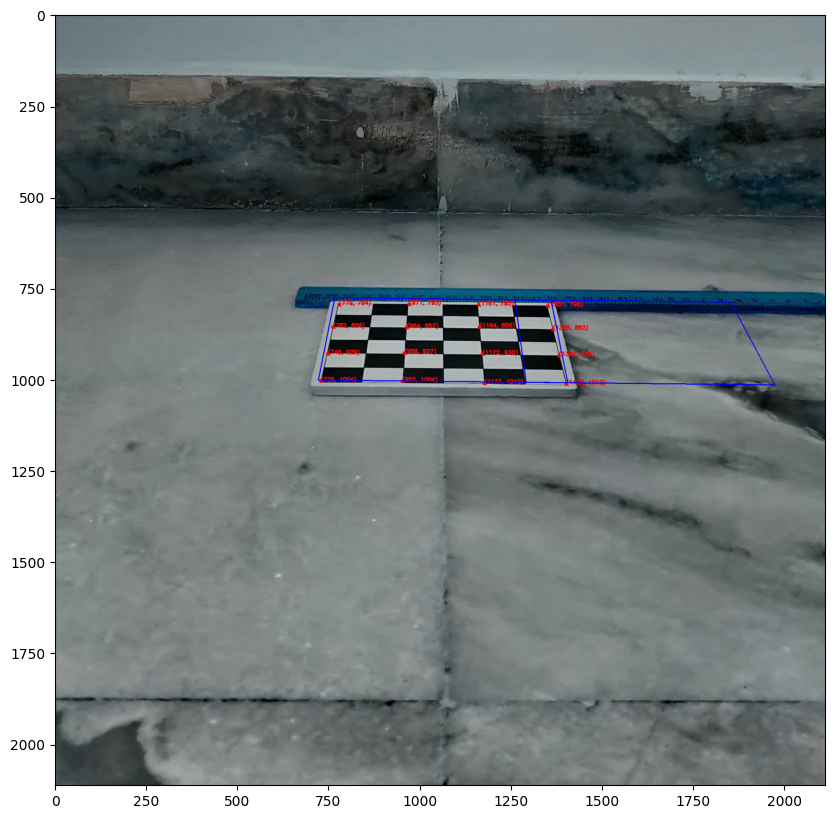

In [173]:
wire_frame1 =cv2.polylines(marked_img1, [image_points2], True, (0, 0, 255), 2)
cv2.imwrite('wire_frame1.jpg', wire_frame1)
plt.figure(figsize=(10, 10))
plt.imshow(wire_frame1)
plt.show()

## Question 3

### 3.1

* declaing world points around the wireframe shifted by 10cm
* finding the corresponding image points using the projection matrix
* overlaying the wireframe on the image

In [112]:
# world points3 = world_points2 + [10,0,0]
world_points3 = np.array([
    [10, 0, 0],
    [10+6*l, 0, 0],
    [10+6*l,6*l,0],
    [10,6*l,0],
])
world_points3 = np.c_[world_points3, np.ones(world_points3.shape[0])]
print(world_points3)

[[10.  0.  0.  1.]
 [22.  0.  0.  1.]
 [22. 12.  0.  1.]
 [10. 12.  0.  1.]]


In [113]:
image_points3 = np.array(np.dot(P1, world_points3.T).T)
image_points3 = image_points3 / image_points3[:, 2].reshape(-1, 1)
image_points3 = image_points3[:, :2]
image_points3 = image_points3.astype(int)

print(image_points3)

[[1261  781]
 [1853  787]
 [1974 1014]
 [1292 1007]]


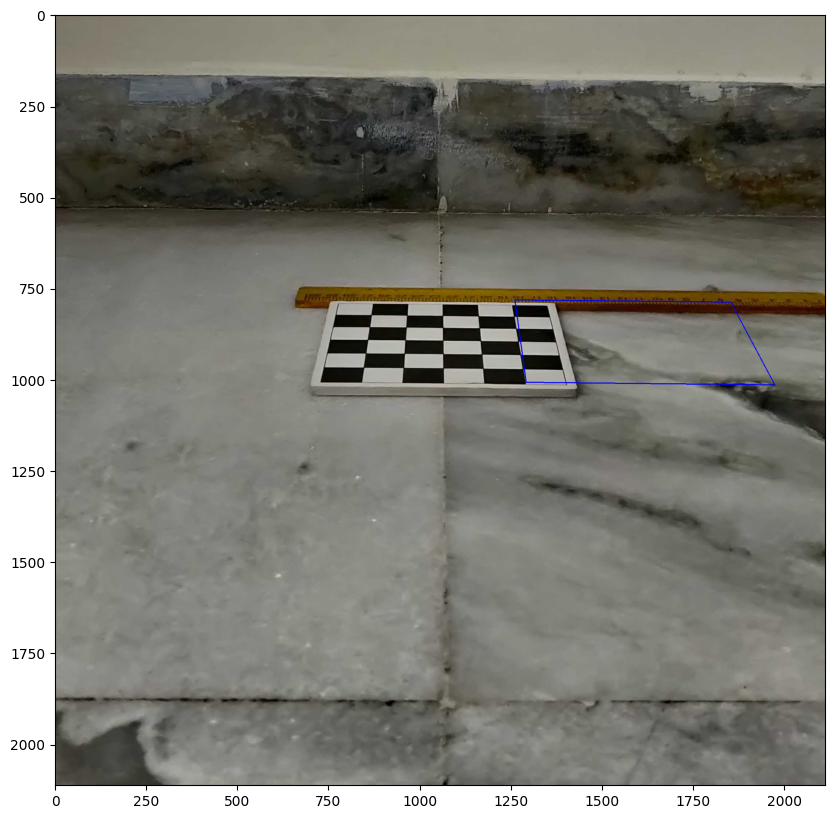

In [115]:
wire_frame2 =cv2.polylines(img1, [image_points3], True, (0, 0, 255), 2)
cv2.imwrite('wire_frame2.jpg', wire_frame2)
plt.figure(figsize=(10, 10))
plt.imshow(wire_frame2)
plt.show()


### 3.2

* forming a grid to copy the values of the image in the chessboard
* copying the values of the image in the chessboard to paste it by shifting 10cm
* displaying the image

In [126]:
grid = np.linspace(0,12,1000)
x,y = np.meshgrid(grid,grid)
points = np.dstack([x,y]).reshape(-1,2)
points = np.float32(np.array([(np.array([x,y,0,1])) for x,y in points]))
print(points)

[[ 0.          0.          0.          1.        ]
 [ 0.01201201  0.          0.          1.        ]
 [ 0.02402402  0.          0.          1.        ]
 ...
 [11.975976   12.          0.          1.        ]
 [11.9879875  12.          0.          1.        ]
 [12.         12.          0.          1.        ]]


In [127]:
image_points4 = np.array(np.dot(P1, points.T).T)
image_points4 = image_points4 / image_points4[:, 2].reshape(-1, 1)
image_points4 = image_points4[:, :2]
image_points4 = image_points4.astype(int)
print(image_points4)

[[ 767  775]
 [ 768  775]
 [ 768  775]
 ...
 [1405 1008]
 [1405 1008]
 [1406 1008]]


In [128]:
modified_points = np.dot(P1,(points+np.array([10,0,0,0])).T).T
modified_points = modified_points / modified_points[:, 2].reshape(-1, 1)
modified_points = modified_points[:, :2]
modified_points = modified_points.astype(int)

print(modified_points)

[[1261  781]
 [1262  781]
 [1263  781]
 ...
 [1973 1014]
 [1974 1014]
 [1974 1014]]


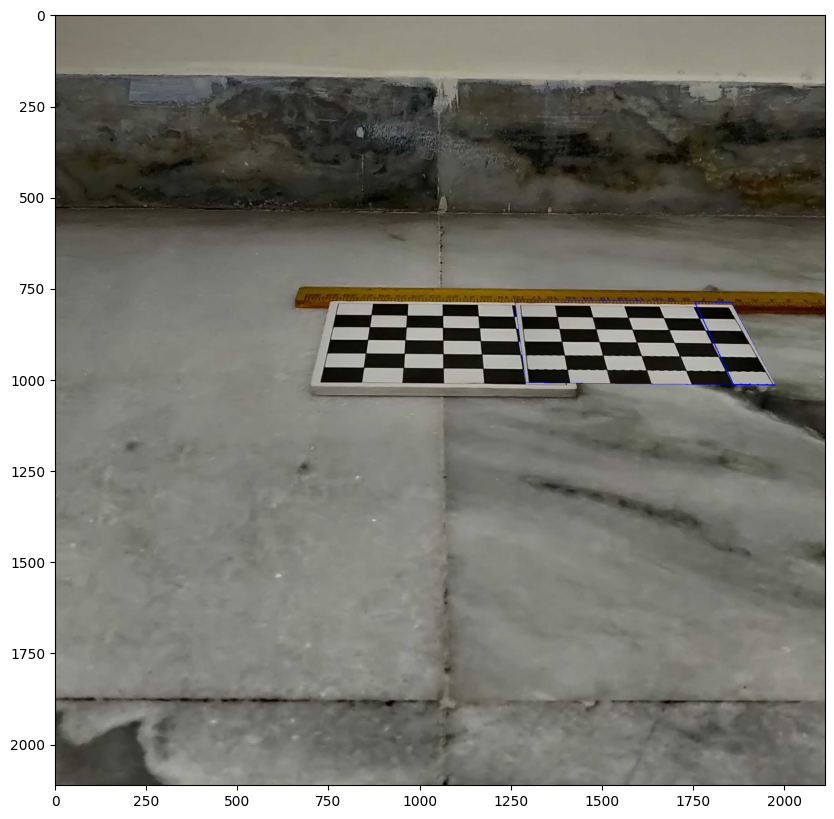

In [129]:
modified_wire = np.copy(wire_frame2)
modified_img = np.copy(img1)
modified_wire[modified_points[:,1], modified_points[:,0],:] = modified_img[image_points4[:,1], image_points4[:,0],:]
cv2.imwrite('modified_wire.jpg', modified_wire)
plt.figure(figsize=(10, 10))
plt.imshow(modified_wire)
plt.show()